In [1]:
print(2+4)

6


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import os
import numpy as np

In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = "True"

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
data_dir = 'hymenoptera_data'#Create a dictionary that contains the information of the images in both the training and validation set
if not os.path.exists(data_dir):
    print(f"Error: The directory '{data_dir}' does not exist!")
else:
    print("Base directory exists.")
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'val']}
#Create a dictionary that contians the data loader
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=4,
                                              shuffle=True) for x in ['train', 'val']}

#Create a dictionary that contains the size of each dataset (training and validation)
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
#Get the class names
class_names = image_datasets['train'].classes
#Print out the results
print("Class Names: {}".format(class_names))
print("There are {} batches in the training set".format(len(dataloaders['train'])))
print("There are {} batches in the test set".format(len(dataloaders['val'])))
print("There are {} training images".format(dataset_sizes['train']))
print("There are {} testing images".format(dataset_sizes['val']))

Base directory exists.
Class Names: ['ants', 'bees']
There are 61 batches in the training set
There are 39 batches in the test set
There are 244 training images
There are 153 testing images


In [6]:
model_conv = torchvision.models.resnet18(weights=True) 

C:\Users\harsh\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
for param in model_conv.parameters():
    param.requires_grad = False

In [8]:
#Get the number of inputs of the last layer (or number of neurons in the layer preceeding the last layer)
num_ftrs = model_conv.fc.in_features 
print(num_ftrs)#maifally has 1000 cats we only need two
#Reconstruct the last layer (output layer) to have only two classes 
model_conv.fc = nn.Linear(num_ftrs, 2)

512


In [9]:
#Understand what's happening
iteration = 0
correct = 0
for inputs,labels in dataloaders['train']:
    if iteration==1:
        break
    inputs = Variable(inputs)
    labels = Variable(labels)
    if torch.cuda.is_available():
        inputs = inputs.cuda()
        labels = labels.cuda()
    print("For one iteration, this is what happens:")
    print("Input Shape:",inputs.shape)
    print("Labels Shape:",labels.shape)
    print("Labels are: {}".format(labels))
    output = model_conv(inputs)
    print("Output Tensor:", output)
    print("Outputs Shape",output.shape)
    _, predicted = torch.max(output, 1)
    print("Predicted:", predicted)
    print("Predicted Shape",predicted.shape)
    correct += (predicted == labels).sum()   
    print("Correct Predictions:",correct)
    
    iteration += 1

For one iteration, this is what happens:
Input Shape: torch.Size([4, 3, 224, 224])
Labels Shape: torch.Size([4])
Labels are: tensor([1, 0, 0, 1])
Output Tensor: tensor([[-0.2073, -0.2528],
        [ 0.2791, -0.7484],
        [ 0.0812, -0.2156],
        [ 0.0948, -0.3427]], grad_fn=<AddmmBackward0>)
Outputs Shape torch.Size([4, 2])
Predicted: tensor([0, 0, 0, 0])
Predicted Shape torch.Size([4])
Correct Predictions: tensor(2)


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_conv.fc.parameters() , lr = 0.001  , momentum = 0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [11]:
num_epochs = 25
for epoch in range (num_epochs):
    exp_lr_scheduler.step()
    correct = 0
    for images,labels in dataloaders['train']:
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
            
        optimizer.zero_grad()
        outputs = model_conv(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()  
        _, predicted = torch.max(outputs, 1) 
        correct += (predicted == labels).sum()
        
    train_acc = 100 * correct / dataset_sizes['train']    
    print ('Epoch [{}/{}], Loss: {:.4f}, Train Accuracy: {}%'
            .format(epoch+1, num_epochs, loss.item(), train_acc))

C:\Users\harsh\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch [1/25], Loss: 0.2952, Train Accuracy: 69.26229858398438%
Epoch [2/25], Loss: 0.1079, Train Accuracy: 77.86885070800781%
Epoch [3/25], Loss: 0.3578, Train Accuracy: 82.3770523071289%
Epoch [4/25], Loss: 0.0459, Train Accuracy: 76.63934326171875%
Epoch [5/25], Loss: 0.8171, Train Accuracy: 75.40983581542969%
Epoch [6/25], Loss: 0.0293, Train Accuracy: 82.7868881225586%
Epoch [7/25], Loss: 0.5692, Train Accuracy: 81.14753723144531%
Epoch [8/25], Loss: 0.4668, Train Accuracy: 84.42623138427734%
Epoch [9/25], Loss: 0.3650, Train Accuracy: 87.70491790771484%
Epoch [10/25], Loss: 0.1335, Train Accuracy: 87.29508209228516%
Epoch [11/25], Loss: 0.5585, Train Accuracy: 82.7868881225586%
Epoch [12/25], Loss: 0.1108, Train Accuracy: 81.96721649169922%
Epoch [13/25], Loss: 0.2178, Train Accuracy: 85.24590301513672%
Epoch [14/25], Loss: 0.7002, Train Accuracy: 86.47541046142578%
Epoch [15/25], Loss: 0.2164, Train Accuracy: 84.42623138427734%
Epoch [16/25], Loss: 0.0831, Train Accuracy: 82.3770

In [12]:
model_conv.eval()  
with torch.no_grad():
    correct = 0
    total = 0
    for (images, labels) in dataloaders['val']:
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        outputs = model_conv(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy: {:.3f} %'.format(100 * correct / total))

Test Accuracy: 93.464 %


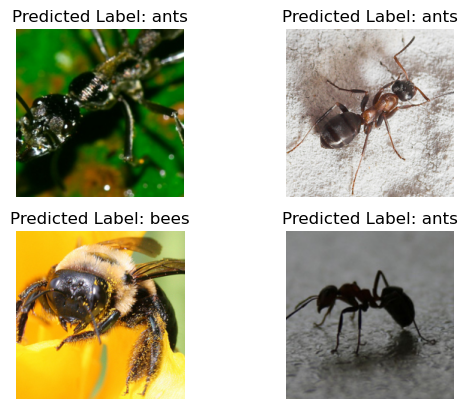

In [13]:
#Visualize some predictions 
import matplotlib.pyplot as plt
fig = plt.figure()
shown_batch = 0
index = 0
with torch.no_grad():
    for (images, labels) in dataloaders['val']:
        if shown_batch == 1:
            break
        shown_batch += 1
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        outputs = model_conv(images)                            #The output is of shape (4,2)
        _, preds = torch.max(outputs, 1)                        #The pred is of shape (4) --> [ 0,  0,  0,  1]
        
        for i in range(4):
            index += 1
            ax = plt.subplot(2,2,index)
            ax.axis('off')
            ax.set_title('Predicted Label: {}'.format(class_names[preds[i]]))
            input_img = images.cpu().data[i]                    #Get the tensor of the image, and put it to cpu  
            inp = input_img.numpy().transpose((1, 2, 0))        #If we have a tensor of shape (2,3,4) --> it becomes (3,4,2)
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp = std * inp + mean
            inp = np.clip(inp, 0, 1)
            plt.imshow(inp)